# Here is the Step3 about SHD Dataset

In [1]:
import pickle
import random
import numpy as np
from scipy import io
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as tnnf
from tqdm.notebook import tqdm

ms = 1e-3 # use this constant so you can write e.g. 1*ms for a time

## Download SHD Dataset and Visualization

Available at: D:/forStudy/IRP/IRP_Neuro_SNN/dataset\hdspikes\shd_train.h5
Available at: D:/forStudy/IRP/IRP_Neuro_SNN/dataset\hdspikes\shd_test.h5
x_train['times'] shape: (8156,)
x_train['units'] shape: (8156,)
y_train shape: (8156,)
x_test['times'] shape: (2264,)
x_test['units'] shape: (2264,)
y_test shape: (2264,)


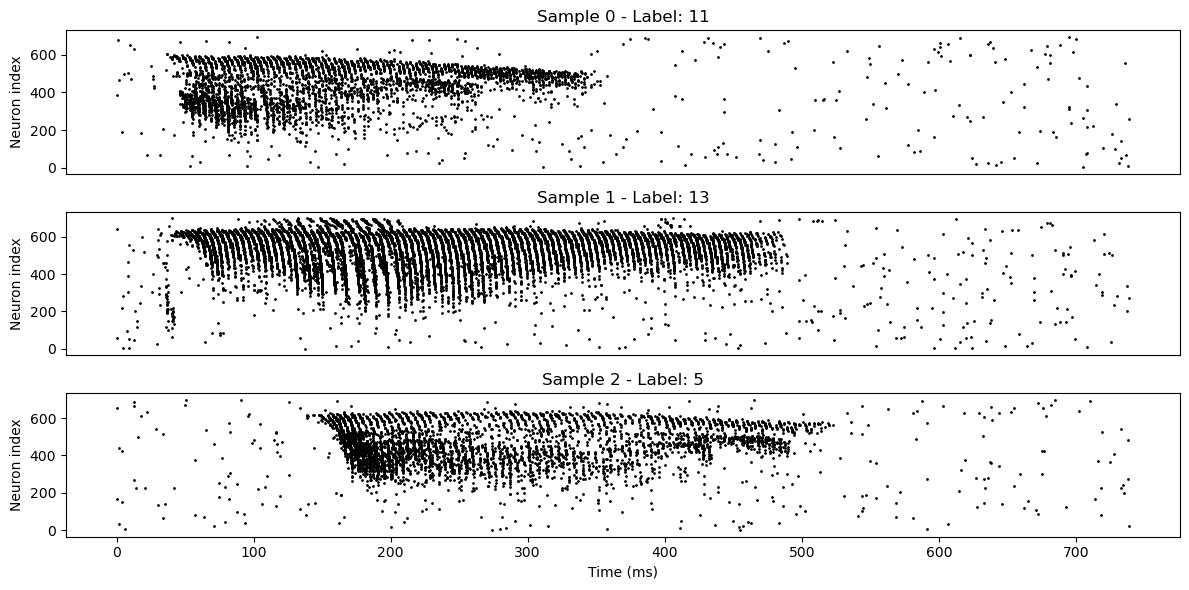

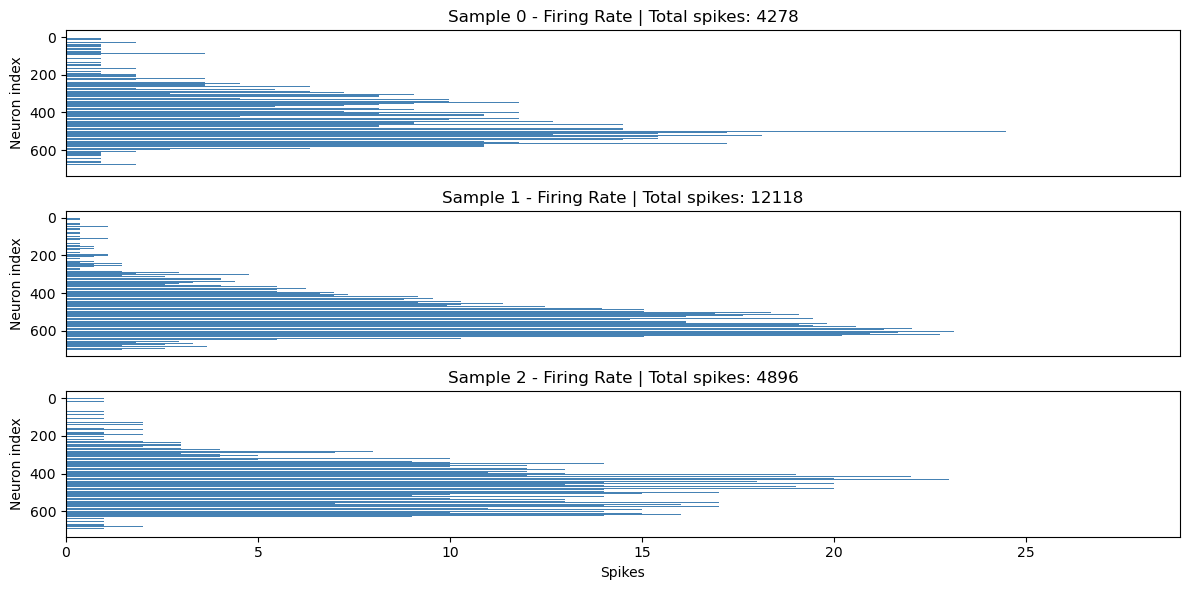

In [2]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# -----------------------------
# 用你提供的 utils.py 中的函数
# -----------------------------
from utils import get_shd_dataset

# ========== 下载 & 解压 ==========
cache_dir = "D:/forStudy/IRP/IRP_Neuro_SNN/dataset"
cache_subdir = "hdspikes"
get_shd_dataset(cache_dir, cache_subdir)

# ========== 加载 HDF5 文件 ==========
base_path = "D:/forStudy/IRP/IRP_Neuro_SNN/dataset/shd"
train_path = os.path.join(base_path, "shd_train.h5")
train_file = h5py.File(train_path, "r")
test_path = os.path.join(base_path, "shd_test.h5")
test_file = h5py.File(test_path, "r")

# ========== 数据结构 ==========
x_train = train_file['spikes']
y_train = train_file['labels']
x_test = test_file['spikes']
y_test = test_file['labels']

n_neurons = 700
max_time = 1.4  # 单位秒
T = 1000        # 总时间(ms)
time_resolution = 1.0
n_time_bins = int(T / time_resolution)

print("x_train['times'] shape:", x_train["times"].shape)
print("x_train['units'] shape:", x_train["units"].shape)
print("y_train shape:", y_train.shape)

print("x_test['times'] shape:", x_test["times"].shape)
print("x_test['units'] shape:", x_test["units"].shape)
print("y_test shape:", y_test.shape)

# ========== 稠密 spike train 构造 + 可视化 ==========
n_samples = 3
spike_trains = []
labels = []

for i in range(n_samples):
    times = x_train["times"][i] * 1000.0  # 秒 → 毫秒
    units = x_train["units"][i]
    label = y_train[i]
    
    spike_train = np.zeros((n_neurons, n_time_bins), dtype=int)
    for t, u in zip(times, units):
        t_idx = int(t / time_resolution)
        if 0 <= u < n_neurons and t_idx < n_time_bins:
            spike_train[u, t_idx] = 1

    spike_trains.append(spike_train)
    labels.append(label)

# ========== Raster Plot ==========
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(n_samples, 1)

for i, spike_train in enumerate(spike_trains):
    ax = plt.subplot(gs[i])
    for neuron_idx in range(spike_train.shape[0]):
        spike_times = np.where(spike_train[neuron_idx] == 1)[0]
        ax.scatter(spike_times, np.ones_like(spike_times) * neuron_idx, s=1, color='black')
    ax.set_ylabel("Neuron index")
    ax.set_title(f"Sample {i} - Label: {labels[i]}")
    if i == n_samples - 1:
        ax.set_xlabel("Time (ms)")
    else:
        ax.set_xticks([])

plt.tight_layout()
plt.show()

# ========== Firing Rate 可视化 ==========
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(n_samples, 1)

for i, spike_train in enumerate(spike_trains):
    ax = plt.subplot(gs[i])
    fr = spike_train.sum(axis=1)
    ax.barh(np.arange(len(fr)), fr, color='steelblue')
    ax.set_title(f"Sample {i} - Firing Rate | Total spikes: {fr.sum()}")
    ax.set_xlim([0, fr.max() + 5])
    ax.invert_yaxis()
    ax.set_ylabel("Neuron index")
    if i == n_samples - 1:
        ax.set_xlabel("Spikes")
    else:
        ax.set_xticks([])

plt.tight_layout()
plt.show()


## Split Dataset and Save as .mat

In [24]:
cache_dir = "D:/forStudy/IRP/IRP_Neuro_SNN/dataset"
cache_subdir = "hdspikes"
get_shd_dataset(cache_dir, cache_subdir)

base_path = "D:/forStudy/IRP/IRP_Neuro_SNN/dataset/shd"
train_path = os.path.join(base_path, "shd_train.h5")
train_file = h5py.File(train_path, "r")
test_path = os.path.join(base_path, "shd_test.h5")
test_file = h5py.File(test_path, "r")

x_train = train_file['spikes']
y_train = train_file['labels']
x_test = test_file['spikes']
y_test = test_file['labels']


# ========== 参数 ==========
batch_size = 256
nb_steps = 100
nb_units = 700
max_time = 1.4  # 秒

# ========== 转换函数 ==========
def sparse_data_generator_from_hdf5_spikes(X, y, batch_size, nb_steps, nb_units, max_time, shuffle=True):
    labels_ = np.array(y, dtype=np.int32)
    number_of_batches = len(labels_) // batch_size
    sample_index = np.arange(len(labels_))
    firing_times = X['times']
    units_fired = X['units']
    time_bins = np.linspace(0, max_time, num=nb_steps)

    if shuffle:
        np.random.shuffle(sample_index)

    counter = 0
    while counter < number_of_batches:
        batch_index = sample_index[batch_size * counter:batch_size * (counter + 1)]
        dense_batch = np.zeros((batch_size, nb_units, nb_steps), dtype=np.uint8)
        y_batch = []

        for bc, idx in enumerate(batch_index):
            times = np.digitize(firing_times[idx], time_bins)
            units = units_fired[idx]
            times[times >= nb_steps] = nb_steps - 1  # 防越界
            dense_batch[bc, units, times] = 1
            y_batch.append(labels_[idx])

        yield dense_batch, np.array(y_batch, dtype=np.uint8)
        counter += 1

# ========== 转换 & 收集 ==========

def collect_all(X_h5, Y_h5):
    X_all = []
    Y_all = []
    for x_batch, y_batch in sparse_data_generator_from_hdf5_spikes(
            X_h5, Y_h5, batch_size, nb_steps, nb_units, max_time, shuffle=False):
        X_all.append(x_batch)
        Y_all.append(y_batch)
    X_all = np.concatenate(X_all, axis=0)
    Y_all = np.concatenate(Y_all, axis=0)
    return X_all, Y_all

X_train_all, Y_train_all = collect_all(x_train, y_train)
X_test_all, Y_test_all = collect_all(x_test, y_test)

# 合并 train 和 test
X_all = np.concatenate([X_train_all, X_test_all], axis=0)
Y_all = np.concatenate([Y_train_all, Y_test_all], axis=0)

# ========== 保存为 .mat ==========
save_path = "D:/forStudy/IRP/IRP_Neuro_SNN/spikedata3.mat"
io.savemat(save_path, {'X': X_all, 'Y': Y_all})

print(f"Saved to: {save_path}")
print(f"X shape: {X_all.shape}, Y shape: {Y_all.shape}")

Available at: D:/forStudy/IRP/IRP_Neuro_SNN/dataset\hdspikes\shd_train.h5
Available at: D:/forStudy/IRP/IRP_Neuro_SNN/dataset\hdspikes\shd_test.h5
Saved to: D:/forStudy/IRP/IRP_Neuro_SNN/spikedata3.mat
X shape: (9984, 700, 100), Y shape: (9984,)


X shape: (9984, 700, 100) Y shape: (9984,)

--- 从生成器中取一个 batch 来看看 ---
生成器产出的 x_batch 形状: (4, 700, 100) y_batch: [ 6 13 17  2]


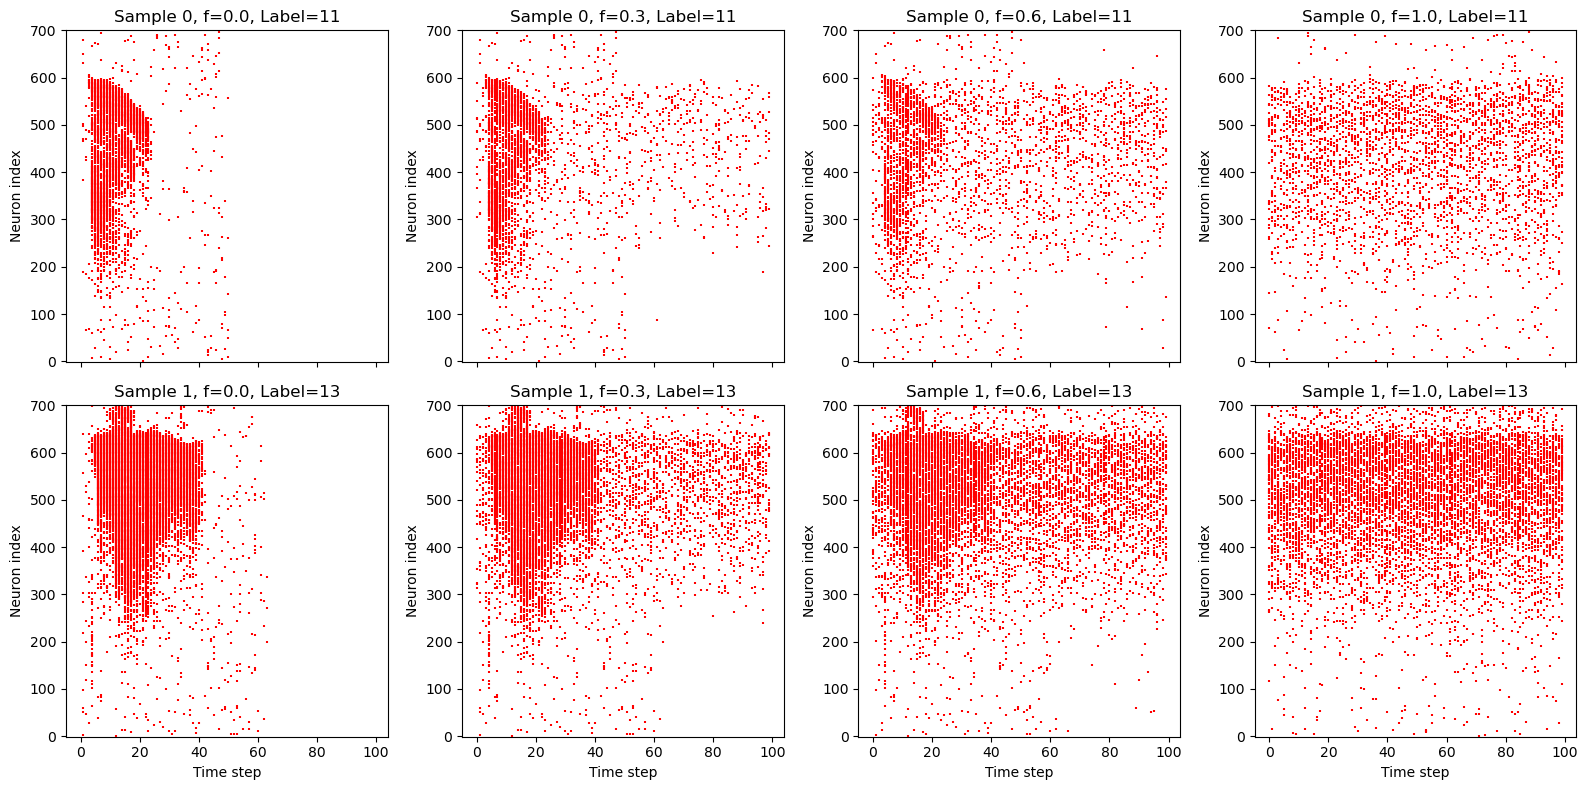

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# 1) 读取 .mat 数据
mat_path = "D:/forStudy/IRP/IRP_Neuro_SNN/spikedata3.mat"  # 按需修改路径
data = loadmat(mat_path)
X = data["X"]  # shape (N, 700, 100)
Y = data["Y"].flatten()  # shape (N,)

N, n_neurons, T = X.shape
print("X shape:", X.shape, "Y shape:", Y.shape)

# 2) 定义“部分随机化 (partial randomize)”函数
def partial_randomize_spike_train(spike_train, f=0.5, max_attempts=50):
    """
    对单个 spike train (形状: (n_neurons, T)) 进行类似 step1.pdf 的“部分随机化”:
      - f:  扰动比例 (0~1)，表示随机化多少比例的脉冲
      - max_attempts: 重新插入时的最大尝试次数 (防止极端情况卡死)
    实际做法：
      1) 随机挑出一部分 (f比例) spike 置0
      2) 再将相同数量的 spike 随机插入到其他时间点
    """
    num_neurons, T = spike_train.shape
    new_train = np.copy(spike_train)

    for neuron_idx in range(num_neurons):
        # 找到该神经元所有脉冲发生的时间索引
        spike_times = np.where(spike_train[neuron_idx] == 1)[0]
        if len(spike_times) == 0:
            continue

        # 计算需要随机化的脉冲数目
        num_to_jitter = int(len(spike_times) * f)
        if num_to_jitter < 1:
            # 如果 f 很小，num_to_jitter=0 时就不做任何随机化
            continue

        # (1) 随机挑出一部分已有脉冲时间，将它们置0
        chosen_times = np.random.choice(spike_times, size=num_to_jitter, replace=False)
        new_train[neuron_idx, chosen_times] = 0

        # (2) 重新插入这 num_to_jitter 个脉冲到其他时间点
        attempts = 0
        inserted = 0
        while inserted < num_to_jitter and attempts < max_attempts * num_to_jitter:
            attempts += 1
            # 随机找一个新的时间位置
            new_t = np.random.randint(0, T)
            # 尽量避免重复插入到已有脉冲处
            if new_train[neuron_idx, new_t] == 0:
                new_train[neuron_idx, new_t] = 1
                inserted += 1

    return new_train

def data_generator_with_randomization(X, Y, batch_size=4, f=0.5, shuffle=True):
    """
    生成器：借鉴 step1.pdf 思路，按 batch 产出【部分随机化后的】(x_batch, y_batch)
      - X.shape = (N, n_neurons, T)
      - Y.shape = (N,)
      - f: 随机化比例
      - shuffle: 是否打乱数据顺序
    在取 batch 的时候再做“部分随机化”，而不是一次性处理所有数据
    """
    N = len(Y)
    indices = np.arange(N)
    if shuffle:
        np.random.shuffle(indices)

    num_batches = N // batch_size
    for b in range(num_batches):
        batch_idx = indices[b * batch_size : (b + 1) * batch_size]

        x_batch = np.zeros((batch_size, X.shape[1], X.shape[2]), dtype=np.uint8)
        y_batch = np.zeros((batch_size,), dtype=np.int32)

        for i, idx in enumerate(batch_idx):
            x_randomized = partial_randomize_spike_train(X[idx], f=f)
            x_batch[i] = x_randomized
            y_batch[i] = Y[idx]

        yield x_batch, y_batch

print("\n--- 从生成器中取一个 batch 来看看 ---")
gen = data_generator_with_randomization(X, Y, batch_size=4, f=0.3, shuffle=True)
x_batch, y_batch = next(gen)
print("生成器产出的 x_batch 形状:", x_batch.shape, "y_batch:", y_batch)

# 3) 可视化: 对同一个样本，测试不同 f 的效果
# 这里先选出若干“样本索引”sample_indexes，每个样本对比 f in [0.0, 0.3, 0.6, 1.0]
sample_indexes = [0, 1]  # 你想可视化哪几个样本，就写在这里
f_values = [0.0, 0.3, 0.6, 1.0]

fig, axes = plt.subplots(len(sample_indexes), len(f_values), figsize=(16, 8), sharex=True)
if len(sample_indexes) == 1:
    axes = [axes]  # 保证可迭代

for i, sample_idx in enumerate(sample_indexes):
    label = Y[sample_idx]  # 该样本的标签
    
    for j, f_val in enumerate(f_values):
        # 对同一个样本做不同 f 的部分随机化
        randomized_train = partial_randomize_spike_train(X[sample_idx], f=f_val)
        
        ax = axes[i][j] if len(sample_indexes)>1 else axes[j]
        # 绘制 raster plot
        for neuron_idx in range(randomized_train.shape[0]):
            spike_times = np.where(randomized_train[neuron_idx] == 1)[0]
            ax.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                       s=2, marker='|', color='red')

        ax.set_title(f"Sample {sample_idx}, f={f_val}, Label={label}")
        ax.set_ylabel("Neuron index")
        ax.set_ylim(-1, randomized_train.shape[0])
        if i == len(sample_indexes) - 1:
            ax.set_xlabel("Time step")

plt.tight_layout()
plt.show()


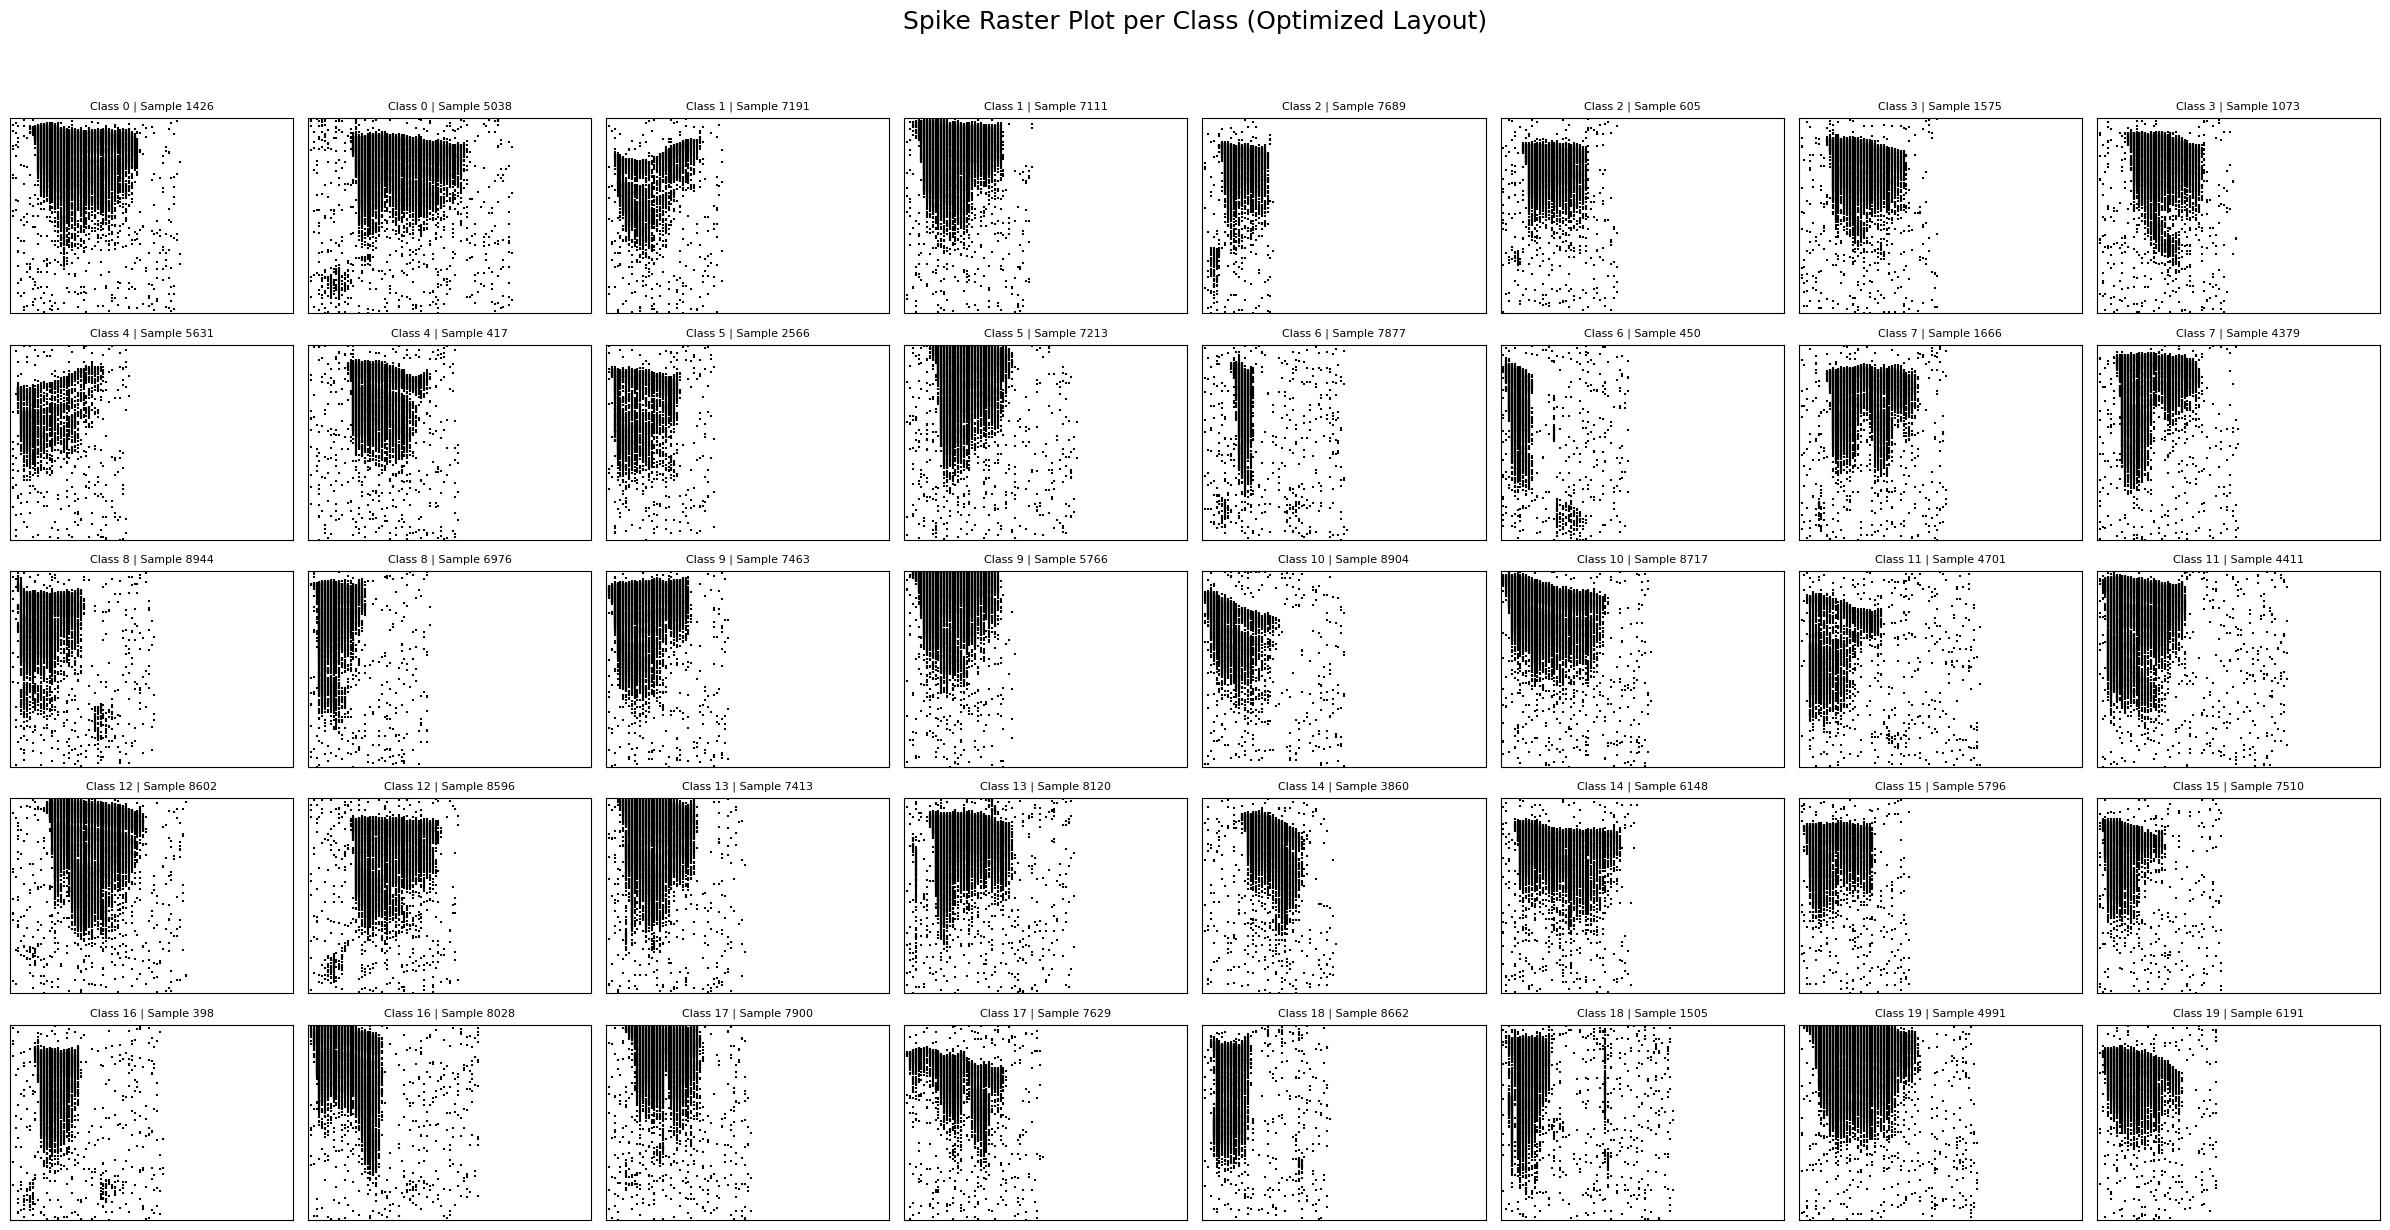

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import math

# ========== 读取数据 ==========
data = io.loadmat('spikedata3.mat')
X = data['X']  # shape = (N, num_neurons, T)
Y = data['Y'].ravel()

N, num_neurons, T = X.shape
unique_labels = np.unique(Y)
num_classes = len(unique_labels)

# ========== 可视化参数 ==========
num_samples_per_class = 2
total_plots = num_classes * num_samples_per_class

# 自动计算行列排布（例如 5 行 × 8 列）
ncols = 8
nrows = math.ceil(total_plots / ncols)

# ========== 选出样本 ==========
np.random.seed(42)
selected_samples = []
for cls in unique_labels:
    cls_indices = np.where(Y == cls)[0]
    selected = np.random.choice(cls_indices, size=num_samples_per_class, replace=False)
    selected_samples.extend([(int(cls), idx) for idx in selected])  # 保存 (类, 样本索引)

# ========== 画图 ==========
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 2.5*nrows), sharex=True, sharey=True)
axes = axes.flatten()
fig.suptitle("Spike Raster Plot per Class (Optimized Layout)", fontsize=18)

for i, (cls, sample_idx) in enumerate(selected_samples):
    ax = axes[i]
    spike_mat = X[sample_idx, :, :]
    for neuron_idx in range(num_neurons):
        spike_times = np.where(spike_mat[neuron_idx] == 1)[0]
        ax.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                   s=1.5, marker='|', color='black')

    ax.set_title(f"Class {cls} | Sample {sample_idx}", fontsize=8)
    ax.set_xlim([0, T])
    ax.set_ylim([0, num_neurons])
    ax.set_xticks([])
    ax.set_yticks([])

# 清除多余子图
for j in range(len(selected_samples), len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Begin Here to Train

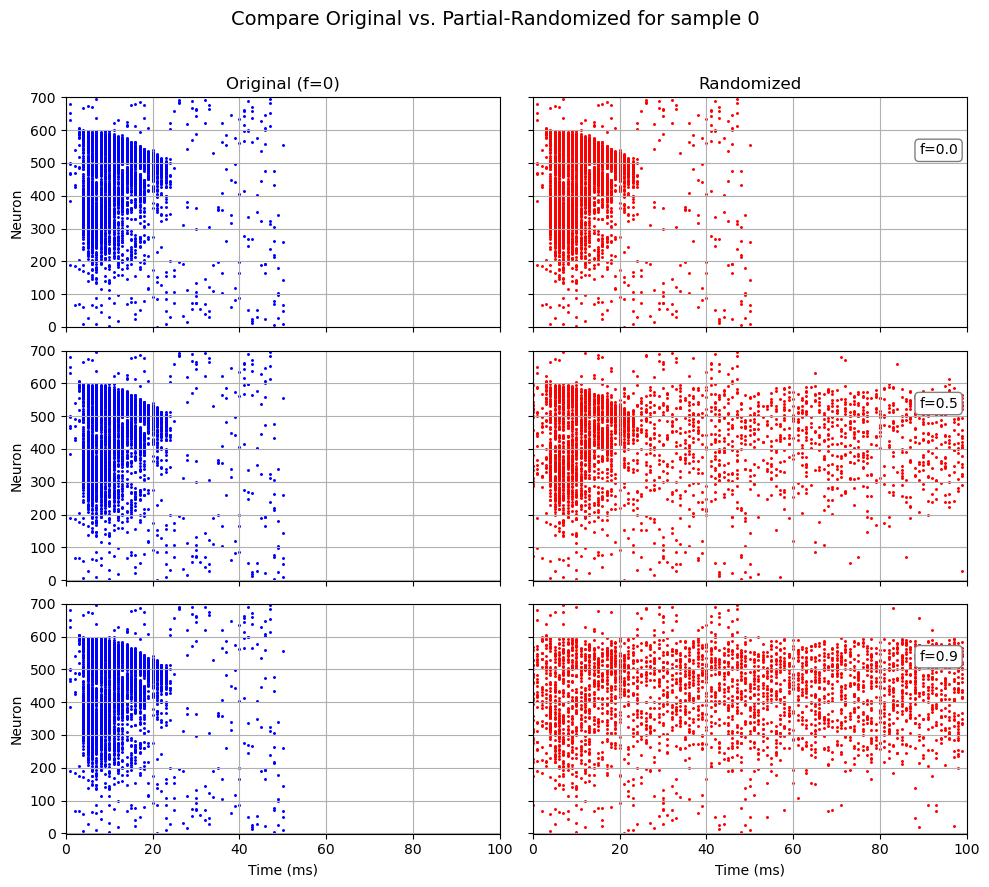

Using data index range = [0, 5990), total 5990 samples
batch_size=2
num_time_points=100
num_batches=2995
RAM usage per batch ~ 0.0010 GB
Got a batch: x_batch.shape=(2, 700, 100), y_batch=[11  1]


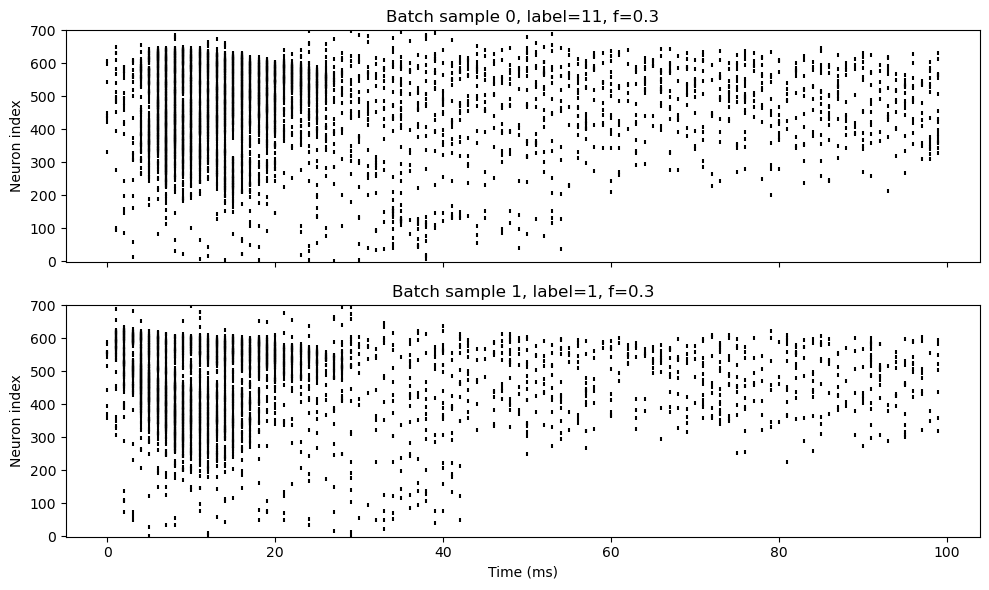

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 1) 定义部分随机化函数
def partial_randomize_spike_train(spike_train, f=0.5, max_attempts=50):
    """
    对单个 spike train(形状: (n_neurons, T)) 做“部分随机化”:
      1) 随机挑出 f 比例的脉冲置0
      2) 将同样数量的脉冲随机插入到其他时刻
    - f: 随机化比例 (0~1)
    - max_attempts: 避免过多插入冲突导致死循环
    返回 new_train, 形状与 spike_train 相同
    """
    if f == 0:
        # 如果 f=0，直接返回原始 spike_train
        return spike_train
        
    num_neurons, T = spike_train.shape
    new_train = np.copy(spike_train)

    for neuron_idx in range(num_neurons):
        spike_times = np.where(spike_train[neuron_idx] == 1)[0]
        if len(spike_times) == 0:
            continue
        num_to_jitter = int(len(spike_times) * f)
        if num_to_jitter < 1:
            continue
        chosen_times = np.random.choice(spike_times, size=num_to_jitter, replace=False)
        new_train[neuron_idx, chosen_times] = 0
        attempts = 0
        inserted = 0
        while inserted < num_to_jitter and attempts < max_attempts * num_to_jitter:
            attempts += 1
            new_t = np.random.randint(0, T)
            if new_train[neuron_idx, new_t] == 0:
                new_train[neuron_idx, new_t] = 1
                inserted += 1

    return new_train
    
def num_batches_if(time_fractions, batch_size=32, max_num_batches=None):
    """
    返回在 time_fractions 范围内能产生多少个 batch
    """
    f_start, f_end = time_fractions
    N = X.shape[0]
    start_idx = int(round(N * f_start))
    end_idx   = int(round(N * f_end))
    sub_len = end_idx - start_idx
    n_batches = sub_len // batch_size
    if max_num_batches is not None:
        n_batches = min(n_batches, max_num_batches)
    return n_batches

# 2) 用 batch 生成器
def batched_data(time_fractions, X, Y, batch_size=4, f=0.5,
                 verbose=False, shuffle=True, max_num_batches=None,
                 max_attempts=50):
    """
    生成器: 只在取 batch 时，对 batch 内的样本做 partial_randomize_spike_train(...).
    避免一次性处理所有数据.
      - time_fractions: (f_start, f_end)，如 (0, 0.6) 表示前 60% 数据
      - f: 随机化比例
      - shuffle: 是否打乱
      - max_num_batches: 限制最多产出的 batch 数
      - max_attempts: 传给 partial_randomize_spike_train

    使用方式:
        for (x_batch, y_batch) in batched_data(...):
            # x_batch.shape = (batch_size, n_neurons, T)
            # y_batch.shape = (batch_size,)
    """
    N = len(Y)
    f_start, f_end = time_fractions
    start_idx = int(round(N * f_start))
    end_idx   = int(round(N * f_end))
    subX = X[start_idx:end_idx]  # [sub_len, n_neurons, T]
    subY = Y[start_idx:end_idx]  # [sub_len]
    sub_len = len(subY)

    indices = np.arange(sub_len)
    if shuffle:
        np.random.shuffle(indices)

    num_batches = sub_len // batch_size
    if max_num_batches is not None:
        num_batches = min(num_batches, max_num_batches)

    num_neurons = X.shape[1]
    num_time_points = X.shape[2]

    if verbose:
        print(f"Using data index range = [{start_idx}, {end_idx}), total {sub_len} samples")
        print(f"{batch_size=}")
        print(f"{num_time_points=}")
        print(f"{num_batches=}")
        print(f"RAM usage per batch ~ {batch_size * num_time_points * num_neurons * 8 / (1024)**3:.4f} GB")

    for b in range(num_batches):
        batch_idx = indices[b*batch_size : (b+1)*batch_size]
        x_batch = np.zeros((batch_size, subX.shape[1], subX.shape[2]), dtype=np.uint8)
        y_batch = np.zeros((batch_size,), dtype=np.int32)
        for i, sidx in enumerate(batch_idx):
            x_random = partial_randomize_spike_train(subX[sidx], f=f, max_attempts=max_attempts)
            x_batch[i] = x_random
            y_batch[i] = subY[sidx]
        yield x_batch, y_batch

# 3) Load SHD Dataset
from scipy.io import loadmat
data = loadmat("spikedata3.mat")
X = data["X"]
Y = data["Y"].ravel()
num_neurons = X.shape[1]
total_samples = X.shape[0]        

training_range   = (0, 0.6)   
validation_range = (0.6, 0.75)
testing_range    = (0.75, 0.9)

# 4) (A) 单个样本: 不同 f 对比
def show_single_sample_different_f(X, Y, sample_idx=0, f_values=[0.0, 0.3, 0.9]):
    """
    对同一个样本 sample_idx 在不同比例 f 下局部随机化，绘制 Spike Raster Plot
    """
    original_st = X[sample_idx]  # shape = (n_neurons, T)
    fig, axes = plt.subplots(len(f_values), 2, figsize=(10, 3 * len(f_values)), sharex=True, sharey=True)
    fig.suptitle(f"Compare Original vs. Partial-Randomized for sample {sample_idx}", fontsize=14)

    for row_i, f_ in enumerate(f_values):
        # Left: Original
        ax_left = axes[row_i, 0]
        for neuron_idx in range(original_st.shape[0]):
            spike_times = np.where(original_st[neuron_idx] == 1)[0]
            ax_left.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                            s=5, color='b', marker='.')
        if row_i == 0:
            ax_left.set_title("Original (f=0)")
        ax_left.set_ylabel('Neuron')
        ax_left.grid(True)

        # Right: Partial Randomized
        x_rand = partial_randomize_spike_train(original_st, f=f_)
        ax_right = axes[row_i, 1]
        for neuron_idx in range(x_rand.shape[0]):
            spike_times = np.where(x_rand[neuron_idx] == 1)[0]
            ax_right.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                             s=5, color='r', marker='.')
        if row_i == 0:
            ax_right.set_title("Randomized")
        ax_right.text(0.98, 0.8, f"f={f_:.1f}", transform=ax_right.transAxes,
                      ha='right', va='top', fontsize=10,
                      bbox=dict(boxstyle="round", fc="white", ec="gray"))
        ax_right.grid(True)

        for ax in (ax_left, ax_right):
            ax.set_ylim([-1, original_st.shape[0]])
            ax.set_xlim([0, original_st.shape[1]])

    axes[-1, 0].set_xlabel('Time (ms)')
    axes[-1, 1].set_xlabel('Time (ms)')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# 4) (B) 批量可视化: 使用生成器
def demo_batch_visualization(X, Y, time_fractions=(0, 0.2), batch_size=2, f=0.5):
    """
    演示如何使用 batched_data(...) 取一个 batch 并可视化
    """
    gen = batched_data(time_fractions, X, Y, batch_size=batch_size, f=f, shuffle=True, verbose=True)
    x_batch, y_batch = next(gen)
    print(f"Got a batch: x_batch.shape={x_batch.shape}, y_batch={y_batch}")

    fig, axes = plt.subplots(batch_size, 1, figsize=(10, 3*batch_size), sharex=True, sharey=True)
    if batch_size == 1:
        axes = [axes]

    for i in range(batch_size):
        ax = axes[i]
        spike_mat = x_batch[i]  # shape=(n_neurons, T)
        for neuron_idx in range(spike_mat.shape[0]):
            spike_times = np.where(spike_mat[neuron_idx] == 1)[0]
            ax.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                       s=5, marker='|', color='black')
        ax.set_title(f"Batch sample {i}, label={y_batch[i]}, f={f}")
        ax.set_ylabel("Neuron index")
        ax.set_ylim([-1, spike_mat.shape[0]])
    axes[-1].set_xlabel("Time (ms)")
    plt.tight_layout()
    plt.show()


show_single_sample_different_f(X, Y, sample_idx=0, f_values=[0.0, 0.5, 0.9])
demo_batch_visualization(X, Y, time_fractions=training_range, batch_size=2, f=0.3)

## Build the Spiking Neural Network Model (SNN)

In [3]:
class SurrogateHeaviside(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrogateHeaviside.scale*torch.abs(input)+1.0)**2
        return grad

# here we overwrite our naive spike function by the "SurrogateHeaviside" nonlinearity which implements a surrogate gradient
surrogate_heaviside  = SurrogateHeaviside.apply

In [82]:
class SNNLayer(nn.Module):
    def __init__(self, n_in, n_out, **params):
        super(SNNLayer, self).__init__()
        self.n_in = n_in
        self.n_out = n_out

        weight_scale = 0.2
        self.w = nn.Parameter(torch.empty((n_in, n_out)))
        self.v = nn.Parameter(torch.empty((n_out, n_out)))  # recurrent

        # Xavier-like init
        nn.init.normal_(self.w, mean=0.0, std=weight_scale / np.sqrt(n_in))
        nn.init.normal_(self.v, mean=0.0, std=weight_scale / np.sqrt(n_out))

        self.params = dict(
            tau_mem=10 * ms,
            tau_syn=5 * ms,
            dt=1 * ms,
        )
        self.params.update(**params)

    def forward(self, x):
        device = x.device
        batch_size, num_neurons, num_time_points = x.shape
        assert num_neurons == self.n_in

        v = torch.zeros((batch_size, self.n_out), device=device)
        s = torch.zeros((batch_size, self.n_out), device=device)
        i = torch.zeros((batch_size, self.n_out), device=device)

        dt = self.params['dt']
        tau_mem = self.params['tau_mem']
        tau_syn = self.params['tau_syn']

        beta = float(np.exp(-dt / tau_mem))
        alpha = float(np.exp(-dt / tau_syn))

        h_input = torch.einsum('bit,ij->bjt', x, self.w.to(device))

        s_rec = []
        for t in range(num_time_points):
            recurrent = torch.matmul(s, self.v)  # (B, H)
            h_t = h_input[:, :, t] + recurrent

            i = alpha * i + h_t
            v = beta * v + i
            s = surrogate_heaviside(v - 1.0)
            v = v * (1 - s)

            s_rec.append(s)

        y = torch.stack(s_rec, dim=2)  # (B, H, T)
        return y


class SpikingNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, tau_mem=10*ms, tau_syn=5*ms, dt=1*ms):
        super(SpikingNet, self).__init__()
        self.hidden_layer = SNNLayer(input_size, hidden_size, tau_mem=tau_mem, tau_syn=tau_syn, dt=dt)
        self.readout_weight = nn.Parameter(torch.empty((hidden_size, output_size)))

        weight_scale = 0.2
        nn.init.normal_(self.readout_weight, mean=0.0, std=weight_scale / np.sqrt(hidden_size))

        self.alpha = float(np.exp(-dt / tau_syn))
        self.beta = float(np.exp(-dt / tau_mem))

    def forward(self, x):
        device = x.device
        batch_size, _, num_time_points = x.shape
        s_hidden = self.hidden_layer(x)  # (B, H, T)

        h2 = torch.einsum("bjt,jk->bkt", s_hidden, self.readout_weight)

        flt = torch.zeros((batch_size, h2.shape[1]), device=device)
        out = torch.zeros((batch_size, h2.shape[1]), device=device)
        out_rec = [out]

        for t in range(num_time_points):
            flt = self.alpha * flt + h2[:, :, t]
            out = self.beta * out + flt
            out_rec.append(out)

        out_rec = torch.stack(out_rec, dim=1).transpose(1, 2)  # (B, O, T+1)
        return out_rec


In [73]:
import torch.nn.functional as F
num_classes = 20

def evaluate_network(net, time_fractions, batch_size=256, f=0.0, device='cpu'):
    net.eval()
    losses = []
    null_losses = []
    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    with torch.no_grad():
        gen = batched_data(time_fractions, X, Y, batch_size=batch_size, f=f, shuffle=False)
        for x, y in gen:
            x = torch.tensor(x, dtype=torch.float32, device=device)
            y = torch.tensor(y, dtype=torch.long, device=device)
            y_out = net(x)  # shape (batch, num_classes, T+1)

            logits = y_out[:, :, 1:]  # remove dummy t=0
            max_logits, _ = torch.max(logits, dim=2)  # max over time
            log_probs = log_softmax_fn(max_logits)

            loss = loss_fn(log_probs, y)
            losses.append(loss.item())

            zero_logits = torch.zeros_like(max_logits)
            null_loss = loss_fn(log_softmax_fn(zero_logits), y)
            null_losses.append(null_loss.item())

    avg_loss = np.mean(losses) if losses else 0.
    avg_null = np.mean(null_losses) if null_losses else 0.
    return avg_loss, avg_null


def train_model(f=0.0, num_epochs=100, batch_size=256, max_num_batches=40, lr=2e-4, hidden_units=200, device='cuda', seed=42):
    print(f"\n=== Training model with f={f}, num_epochs={num_epochs}, seed={seed} ===")

    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    device = torch.device(device if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    net = SpikingNet(num_neurons, hidden_units, num_classes).to(device)

    optimizer = torch.optim.Adamax(net.parameters(), lr=lr, betas=(0.9, 0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    loss_hist, val_loss_hist = [], []
    best_val_loss = float('inf')
    best_model_state = None

    train_batches = num_batches_if(training_range, batch_size=batch_size, max_num_batches=max_num_batches)
    total_batches = num_epochs * train_batches

    from tqdm import tqdm
    with tqdm(total=total_batches) as pbar:
        for epoch in range(num_epochs):
            net.train()
            local_loss = []
            train_gen = batched_data(training_range, X, Y, batch_size=batch_size, f=f, shuffle=True,
                                     verbose=(epoch==0), max_num_batches=max_num_batches)
            for x, y in train_gen:
                x = torch.tensor(x, dtype=torch.float32, device=device)
                y = torch.tensor(y, dtype=torch.long, device=device)

                y_out = net(x)  # (batch, num_classes, T+1)
                logits = y_out[:, :, 1:]  # 丢掉 t=0 的 dummy 值

                max_logits, _ = torch.max(logits, dim=2)  # 对时间做 max pooling, 得到 shape (batch, num_classes)
                log_probs = log_softmax_fn(max_logits)

                # === regularizer based on spike activity ===
                spk_hidden = net.hidden_layer(x)  # shape (B, hidden, T)
                l1_loss = 2e-6 * torch.sum(spk_hidden)
                l2_loss = 2e-6 * torch.mean(torch.sum(torch.sum(spk_hidden, dim=0), dim=0)**2)
                reg_loss = l1_loss + l2_loss

                loss = loss_fn(log_probs, y) + reg_loss
                local_loss.append(loss.item())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                pbar.update(1)

            last_epoch_loss = np.mean(local_loss) if local_loss else 0.
            val_loss, null_val_loss = evaluate_network(net, validation_range, batch_size=batch_size, f=f, device=device)
            val_loss_hist.append(val_loss)
            loss_hist.append(last_epoch_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = net.state_dict()

            pbar.set_postfix(
                epoch=epoch,
                train_loss=last_epoch_loss,
                val_loss=val_loss,
                null_val=null_val_loss
            )

    plt.figure()
    plt.semilogy(loss_hist, label='Train loss')
    plt.semilogy(val_loss_hist, label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    if best_model_state is not None:
        net.load_state_dict(best_model_state)
        print(f"Loaded best model with val_loss={best_val_loss:.4f}")

    test_loss, null_test_loss = evaluate_network(net, testing_range, batch_size=batch_size, f=f, device=device)
    print(f"Final Test: test_loss={test_loss:.4f}, null_test_loss={null_test_loss:.4f}")

    return net, best_val_loss

def test_accuracy(net, time_fractions=testing_range, batch_size=256, f=0, device='cpu'):
    net.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        gen = batched_data(time_fractions, X, Y, batch_size=batch_size, f=f, shuffle=False)
        for x, y in gen:
            x = torch.tensor(x, dtype=torch.float32, device=device)
            y = torch.tensor(y, dtype=torch.long, device=device)

            y_out = net(x)  # shape: (batch, num_classes, T+1)
            logits = y_out[:, :, 1:]  # 去掉 dummy 第0步
            max_logits, _ = torch.max(logits, dim=2)  # shape: (batch, num_classes)

            preds = torch.argmax(max_logits, dim=1)
            correct += (preds == y).sum().item()
            total   += y.size(0)

    return correct / total if total > 0 else 0.


### Training model for f = 0 ###

=== Training model with f=0, num_epochs=200, seed=42 ===
Using device: cuda


  0%|          | 0/4600 [00:00<?, ?it/s]

Using data index range = [0, 5990), total 5990 samples
batch_size=256
num_time_points=100
num_batches=23
RAM usage per batch ~ 0.1335 GB


100%|██████████| 4600/4600 [41:23<00:00,  1.85it/s, epoch=199, null_val=3, train_loss=1.06, val_loss=1.22]


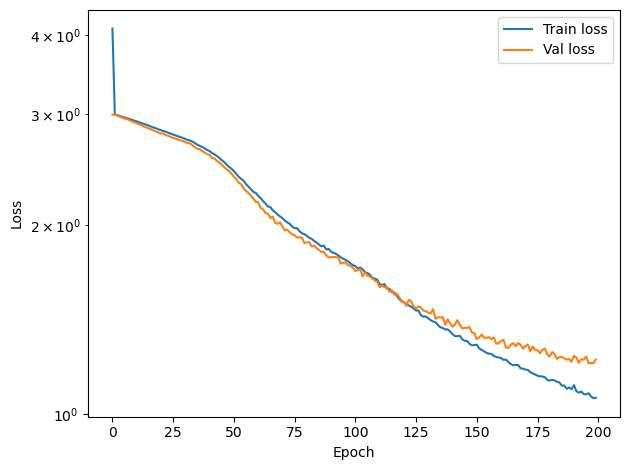

Loaded best model with val_loss=1.2051
Final Test: test_loss=1.5353, null_test_loss=2.9957
Saved model: s3_f00.pt
f=0.0, Test Accuracy: 54.19%


In [76]:
f_values = [0]

for f in f_values:
    print(f"\n### Training model for f = {f} ###")

    var_name = f"net_{int(f * 10):02d}" 
    net, val_loss = train_model(f=f, num_epochs=200)
    globals()[var_name] = net
    model_path = f"s3_f{int(f * 10):02d}.pt"
    torch.save(net.state_dict(), model_path)
    print(f"Saved model: {model_path}")
    acc = test_accuracy(net, testing_range, batch_size=128, f=f, device='cuda')
    print(f"f={f:.1f}, Test Accuracy: {acc:.2%}")


### Training model for f = 0 ###

=== Training model with f=0, num_epochs=300, seed=42 ===
Using device: cuda


  0%|          | 0/6900 [00:00<?, ?it/s]

Using data index range = [0, 5990), total 5990 samples
batch_size=256
num_time_points=100
num_batches=23
RAM usage per batch ~ 0.1335 GB


100%|██████████| 6900/6900 [56:58<00:00,  2.02it/s, epoch=299, null_val=3, train_loss=0.8, val_loss=1.17]  


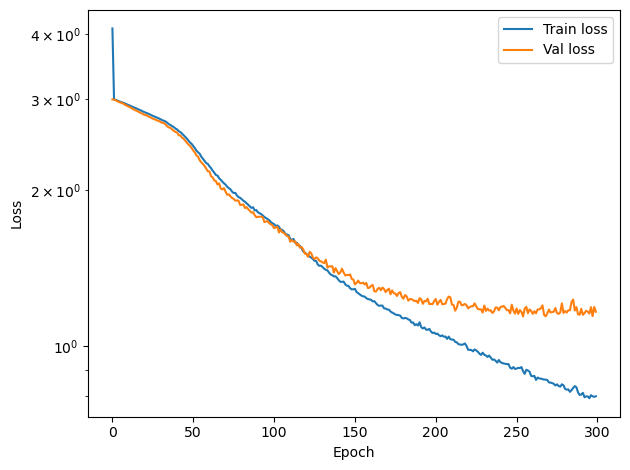

Loaded best model with val_loss=1.1410
Final Test: test_loss=1.6406, null_test_loss=2.9957
Saved model: ss3_f00.pt
f=0.0, Test Accuracy: 54.69%

### Training model for f = 0.5 ###

=== Training model with f=0.5, num_epochs=300, seed=42 ===
Using device: cuda


  0%|          | 0/6900 [00:00<?, ?it/s]

Using data index range = [0, 5990), total 5990 samples
batch_size=256
num_time_points=100
num_batches=23
RAM usage per batch ~ 0.1335 GB


100%|██████████| 6900/6900 [9:55:50<00:00,  5.18s/it, epoch=299, null_val=3, train_loss=0.947, val_loss=1.1]   


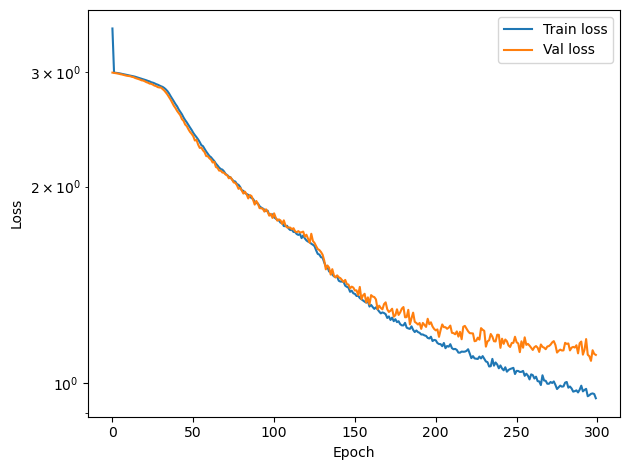

Loaded best model with val_loss=1.0808
Final Test: test_loss=1.3181, null_test_loss=2.9957
Saved model: ss3_f05.pt
f=0.5, Test Accuracy: 58.24%

### Training model for f = 0.9 ###

=== Training model with f=0.9, num_epochs=300, seed=42 ===
Using device: cuda


  0%|          | 0/6900 [00:00<?, ?it/s]

Using data index range = [0, 5990), total 5990 samples
batch_size=256
num_time_points=100
num_batches=23
RAM usage per batch ~ 0.1335 GB


  3%|▎         | 238/6900 [39:10<18:16:29,  9.88s/it, epoch=9, null_val=3, train_loss=2.95, val_loss=2.93]


KeyboardInterrupt: 

In [83]:
f_values = [0,0.5,0.9]

for f in f_values:
    print(f"\n### Training model for f = {f} ###")

    var_name = f"net_{int(f * 10):02d}" 
    net, val_loss = train_model(f=f, num_epochs=300)
    globals()[var_name] = net
    model_path = f"ss3_f{int(f * 10):02d}.pt"
    torch.save(net.state_dict(), model_path)
    print(f"Saved model: {model_path}")
    acc = test_accuracy(net, testing_range, batch_size=128, f=f, device='cuda')
    print(f"f={f:.1f}, Test Accuracy: {acc:.2%}")

## Evaluation

Using device: cuda

=== Loading model ss3_f00.pt and testing ===
f=0.0, Test Accuracy: 54.69%

=== Loading model ss3_f05.pt and testing ===
f=0.5, Test Accuracy: 56.82%


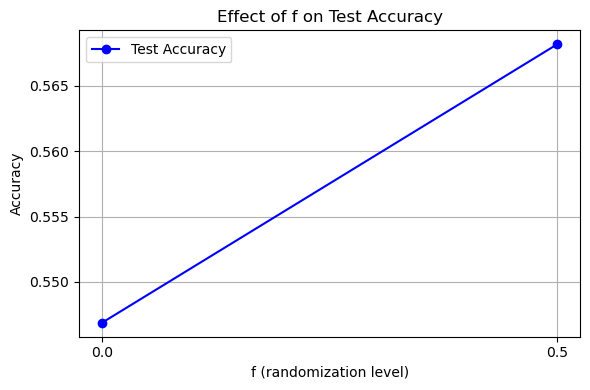

In [88]:
import torch
import matplotlib.pyplot as plt
from scipy import io

# 加载数据
data = io.loadmat('spikedata3.mat')
X = data['X']  # (N, num_neurons, T)
Y = data['Y'].ravel()

f_values = [0.0,0.5]
accuracies = []

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 遍历 f 值，加载模型并测试
for f in f_values:
    model_path = f"ss3_f{int(f*10):02d}.pt"
    print(f"\n=== Loading model {model_path} and testing ===")

    # 构建网络（注意使用你当前定义的 SpikingNet 类）
    net = SpikingNet(num_neurons, 200, num_classes)
    net.load_state_dict(torch.load(model_path, map_location=device))
    net.to(device)

    # 评估准确率
    acc = test_accuracy(net, time_fractions=testing_range, batch_size=128, f=f, device=device)
    accuracies.append(acc)
    print(f"f={f:.1f}, Test Accuracy: {acc:.2%}")

# 绘图
plt.figure(figsize=(6, 4))
plt.plot(f_values, accuracies, marker='o', linestyle='-', color='b', label="Test Accuracy")
plt.xlabel("f (randomization level)")
plt.ylabel("Accuracy")
plt.title("Effect of f on Test Accuracy")
plt.xticks(f_values)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Debug


Sample 3, Label = 8, Spike count = 60.0


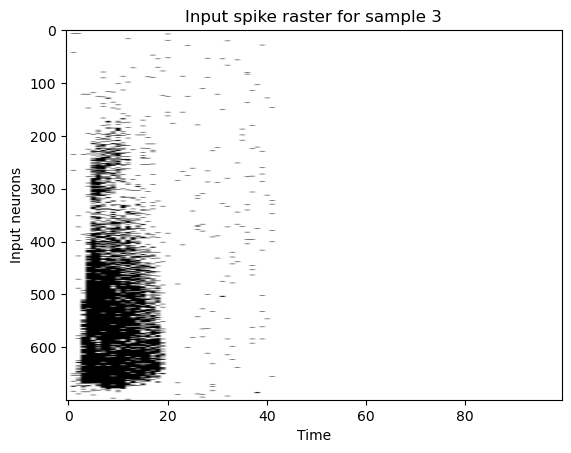

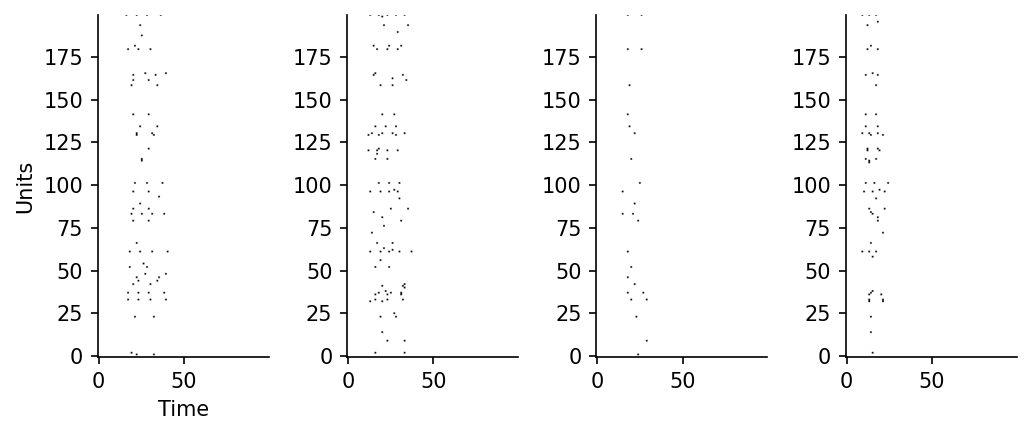

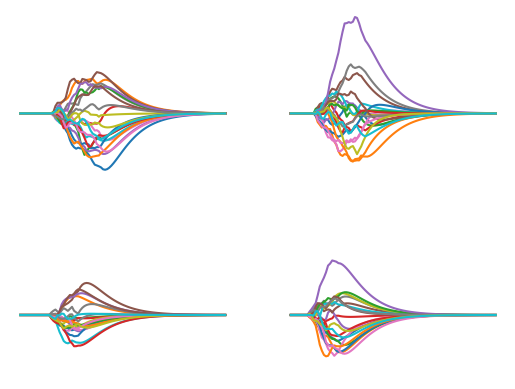

In [71]:
# === 获取一个 mini-batch（dense） ===
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns

batch_size = 4  # 小一点方便可视化
gen = batched_data((0.5, 0.6), X, Y, batch_size=batch_size, f=0.0, shuffle=False)
x_batch_np, y_batch_np = next(gen)

# 转为 tensor
x_batch = torch.tensor(x_batch_np, dtype=torch.float32, device=device)
y_batch = torch.tensor(y_batch_np, dtype=torch.long, device=device)

# === Debug 网络结构，带返回 spike 和 voltage trace ===
class DebugNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, tau_mem=10*ms, tau_syn=5*ms, dt=1*ms):
        super(DebugNet, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size

        weight_scale = 0.05
        dtype = torch.float

        # Input → Hidden
        self.w1 = nn.Parameter(torch.empty((input_size, hidden_size), dtype=dtype))
        # Hidden → Output
        self.w2 = nn.Parameter(torch.empty((hidden_size, output_size), dtype=dtype))
        # Recurrent Hidden → Hidden
        self.v1 = nn.Parameter(torch.empty((hidden_size, hidden_size), dtype=dtype))

        # Xavier-like init
        nn.init.normal_(self.w1, mean=0.0, std=weight_scale / np.sqrt(input_size))
        nn.init.normal_(self.w2, mean=0.0, std=weight_scale / np.sqrt(hidden_size))
        nn.init.normal_(self.v1, mean=0.0, std=weight_scale / np.sqrt(hidden_size))

        self.alpha = float(np.exp(-dt / tau_syn))
        self.beta = float(np.exp(-dt / tau_mem))

    def forward(self, x):  # x: (B, N_in, T)
        device = x.device
        batch_size, _, num_time_points = x.shape
        dtype = x.dtype

        # 初始化状态
        syn = torch.zeros((batch_size, self.hidden_size), device=device, dtype=dtype)
        mem = torch.zeros((batch_size, self.hidden_size), device=device, dtype=dtype)
        out = torch.zeros((batch_size, self.hidden_size), device=device, dtype=dtype)

        mem_rec, spk_rec = [], []

        # 预计算输入的 w1
        h1_from_input = torch.einsum("bit,ij->bjt", x, self.w1)  # (B, H, T)

        for t in range(num_time_points):
            h1_t = h1_from_input[:, :, t]
            recurrent = torch.matmul(out, self.v1)
            h1 = h1_t + recurrent

            mthr = mem - 1.0
            out = surrogate_heaviside(mthr)
            rst = out.detach()  # 不反传 reset

            syn = self.alpha * syn + h1
            mem = (self.beta * mem + syn) * (1.0 - rst)

            mem_rec.append(mem)
            spk_rec.append(out)

        mem_rec = torch.stack(mem_rec, dim=1).permute(0, 2, 1)  # (B, H, T)
        spk_rec = torch.stack(spk_rec, dim=1).permute(0, 2, 1)  # (B, H, T)

        # Readout 层
        h2 = torch.einsum("bjt,jk->bkt", spk_rec, self.w2)  # (B, O, T)

        flt = torch.zeros((batch_size, self.output_size), device=device, dtype=dtype)
        out = torch.zeros((batch_size, self.output_size), device=device, dtype=dtype)
        out_rec = [out]

        for t in range(num_time_points):
            flt = self.alpha * flt + h2[:, :, t]
            out = self.beta * out + flt
            out_rec.append(out)

        out_rec = torch.stack(out_rec, dim=1).transpose(1, 2)  # (B, O, T+1)
        return out_rec, (mem_rec, spk_rec)



def plot_voltage_traces(mem, spk=None, dim=(2, 2), spike_height=5):
    assert mem.dim() == 3, "输入 mem 必须是 3 维 (batch, neuron, time)"
    B, C, T = mem.shape
    N = B  # 画每个样本的 logit 曲线
    gs = GridSpec(*dim)
    mem = mem.detach().cpu().numpy()

    if spk is not None:
        spk = spk.detach().cpu().numpy()
        dat = mem.copy()
        dat[spk > 0.0] = spike_height
    else:
        dat = mem

    for i in range(N):
        if i == 0:
            a0 = ax = plt.subplot(gs[i])
        else:
            ax = plt.subplot(gs[i], sharey=a0)
        for k in range(C):  # 每个类的 logit 曲线
            ax.plot(dat[i, k, :])
        ax.axis("off")


# === 实例化并运行网络 ===
net = DebugNet(input_size=700, hidden_size=200, output_size=20).to(device)
output, (mem_rec, spk_rec) = net(x_batch)
print(f"Sample {i}, Label = {y_batch_np[i]}, Spike count = {spk_rec[i].sum().item()}")
plt.imshow(x_batch[i].detach().cpu().numpy(), aspect='auto', cmap='gray_r')
plt.title(f"Input spike raster for sample {i}")
plt.xlabel("Time")
plt.ylabel("Input neurons")

# === 可视化 hidden 层 spike activity ===
nb_plt = 4
gs = GridSpec(1, nb_plt)
fig = plt.figure(figsize=(7, 3), dpi=150)
for i in range(nb_plt):
    plt.subplot(gs[i])
    plt.imshow(spk_rec[i].detach().cpu().numpy(), cmap=plt.cm.gray_r, origin="lower")
    if i == 0:
        plt.xlabel("Time")
        plt.ylabel("Units")
    sns.despine()
plt.tight_layout()
plt.show()

# output shape: (B, num_classes, T+1)
# 你可以只取后 T 步，也可以全画
plot_voltage_traces(output[:, :, 1:], dim=(2, 2))  # 画前4个样本的输出电压
plt.show()
